### Task
Create a method for image matching with **no labeled data** for fashion products.

There are two groups of photos, one group(targets) represents the different products, and another group(queries) are photos taken by employees or users. The task is to match the query photo with the corresponding photo in the target group.

![Untitled (1).jpg][def]


[def]: <Untitled (1).jpg>

### Method

The challenge is to construct a prediction model with no labeled data. 
There are some reported methods for labeled data [1-3]. Template matching[4] might not work here as well, as the query is potentially far from nearly duplicate of target photos[5].

In this notebook, I am attempting apply transfer learning on a pre-trained image classifier for a features extractor. Then apply the nearest neighbor model. The distance metric is cosine similarity.
However, as the original image classifier was not trained on fashion data, the out-of-the-box performance is not good, this notebook also attempts to improve its performance. 

![Untitled.jpg][def]

The idea is to orthogonalize the target photos, as the embedded vector is usually ~1000(i.e. efficientnet features output is 1280). As long as the number of input photos is less than the dimension of the features vector, it's guaranteed to make all inputs vector orthogonal.

(note: many potential variations exist, see discussion for details)


[def]: <Untitled.jpg>

### Code

The following implementation is based on Python and Pytorch package.

Features extractor is made by substituting the classifier layer in pre-trained models from torchvision.models(https://pytorch.org/vision/stable/models.html) with a Identity layer(forward call returns its input). The implementation of Identity layer can be found in some_code.py.

In [215]:
# import all needed packages
import some_code as K #some auxiliary code, due to readability I put in seperate file. A copy can also been found at the end
from importlib import reload
reload(K)

import torch, torchvision
from torch import Tensor, nn, optim
from torchvision import transforms, models

from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

# to fix the convextnet hash issue (ref: https://github.com/pytorch/vision/issues/7744)
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

data_path = Path("data/UNIQOExample")

Using cpu


In [208]:
result, model_names = {"DEFAULT": [], None:[]}, []
transforms_default = K.ToTensor_and_Resize(224)
models_to_try = [
    (models.alexnet, transforms_default), #min_size 63
    (models.densenet121, transforms_default), #29
    (models.convnext_tiny, transforms_default), #32
    (models.efficientnet_b0, transforms_default), #1
    (models.googlenet, transforms_default), #224
    (models.inception_v3, K.ToTensor_and_Resize(299)), #299
    (models.maxvit_t, transforms_default), #224
    (models.mnasnet0_5, models.MNASNet0_5_Weights.IMAGENET1K_V1.transforms ), #1
    (models.mobilenet_v3_small, transforms_default), #1
] #tuple(model_constructor, transforms for inputs image)

for model_constructor, transforms_needed in models_to_try:
    for weight in ["DEFAULT", None]:

        (inputs, input_files, labels), (match_targets, match_files, match_labels) = K.load_data(data_path, transforms_needed)
        inputs, match_targets = inputs.to(device), match_targets.to(device)

        # make model by architecture specified and turn off the classfier in the orginal model
        model = K.FeaturesExtractor(model_constructor, weights = weight, frozen = True)
        model.to(device)
        
        # featurize input and match samples, then normalize to 1(by row aka each sample)
        outputs = model(inputs)
        match_sapce = model(match_targets)
        topk_error_rate, (cos_similaritys, top_classes) = K.error_rate(labels, match_labels, outputs, match_sapce, k = 5)
        
        result[weight].append(topk_error_rate)
    model_names.append(model.name)

print(pd.DataFrame(result, index=model_names))

c:\Users\kit97\Documents\GitHub\PaddleLearing\.conda\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
c:\Users\kit97\Documents\GitHub\PaddleLearing\.conda\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


,DEFAULT,None
AlexNet,0.483871,0.451613
DenseNet,0.322581,0.419355
ConvNeXt,0.419355,0.548387
EfficientNet,0.258065,0.548387
GoogLeNet,0.387097,0.516129
Inception3,0.354839,0.419355
MaxVit,0.096774,0.516129
MNASNet,0.451613,0.548387
MobileNetV3,0.322581,0.548387


As shown although the models were trained on the ImageNet dataset, which contains mostly animals and daily objects, the FeaturesExtractor is still able to distall meaningful features.
However, except for MaxVit model, all other models top-5 error rates were above 25%, which is quite bad.
As the distance metric is the cosine similarity, if the target vectors are more evenly spaced, would probably result in better resolution.
Thus we can use the sum of pairwise dot-products of target tensors as a loss function to train the FeaturesExtractor. By minimizing the sum of pairwise dot-product, the vectors are more orthogonal thus more distance more each other.

AlexNet:
iter 0 done iter 1 done iter 2 done iter 3 done iter 4 done iter 5 done iter 6 done iter 7 done iter 8 done iter 9 done iter 10 done iter 11 done iter 12 done iter 13 done iter 14 done 
AlexNet Done, inital topk error rate =  25.8%, best = 25.8%


<Axes: title={'center': 'AlexNet'}, xlabel='iter cycle', ylabel='top 5 error rate'>

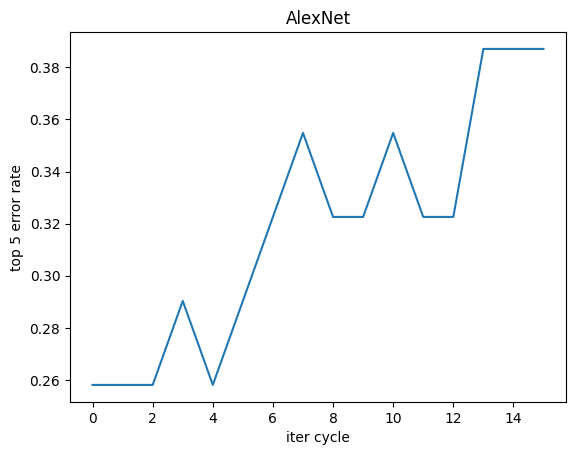

In [227]:
(inputs, input_files, labels), (match_targets, match_files, match_labels) = K.load_data(data_path, models.AlexNet_Weights.IMAGENET1K_V1.transforms())
inputs, match_targets = inputs.to(device), match_targets.to(device)
model = K.FeaturesExtractor(models.alexnet, weights="DEFAULT", frozen=False)
model.to(device)
print(f"{model.name}:")

loss_tracking, error_rate_tracking = [], []
with torch.no_grad():
    model.eval()
    topk_error_rate, _ = K.error_rate(labels, match_labels, model(inputs), model(match_targets), k = 5)
    error_rate_tracking.append(topk_error_rate)

optimizer = optim.Adam(model.parameters(), lr = 0.00005)
criterion = K.PairwiseDotproducts() # sum of pairwaise dot-product as loss function

for iter_index in range(15):
    model.train()
    match_sapce = model(match_targets)
    loss = criterion(match_sapce)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_tracking.append(loss.item())

    with torch.no_grad():
        model.eval()
        topk_error_rate, _ = K.error_rate(labels, match_labels, model(inputs), model(match_targets), k = 5)
        error_rate_tracking.append(topk_error_rate)
    print(f"iter {iter_index} done", end=" ")

print(f"\n{model.name} Done, inital topk error rate = {error_rate_tracking[0]*100: .1f}%, best = {min(error_rate_tracking)*100 :.1f}%")

error_rate_tracking = pd.Series(error_rate_tracking)
plt.close()
plt.figure()
error_rate_tracking.plot(title=model.name, xlabel="iter cycle", ylabel="top 5 error rate")

With Alexnet as an example, by orthogonazing the matching matrix the error rate is decreased. Also, this behavior is not limited to Alexnet. The following code shows the result for 9 pre-trained models.

AlexNet:

AlexNet Done, inital topk error rate =  48.4%, best = 48.4%
DenseNet:

DenseNet Done, inital topk error rate =  32.3%, best = 22.6%
ConvNeXt:

ConvNeXt Done, inital topk error rate =  41.9%, best = 16.1%
EfficientNet:

EfficientNet Done, inital topk error rate =  25.8%, best = 25.8%
GoogLeNet:

GoogLeNet Done, inital topk error rate =  38.7%, best = 38.7%
Inception3:

Inception3 Done, inital topk error rate =  35.5%, best = 32.3%
MaxVit:

MaxVit Done, inital topk error rate =  9.7%, best = 9.7%
MNASNet:

MNASNet Done, inital topk error rate =  45.2%, best = 45.2%
MobileNetV3:

MobileNetV3 Done, inital topk error rate =  32.3%, best = 32.3%


array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

<Figure size 640x480 with 0 Axes>

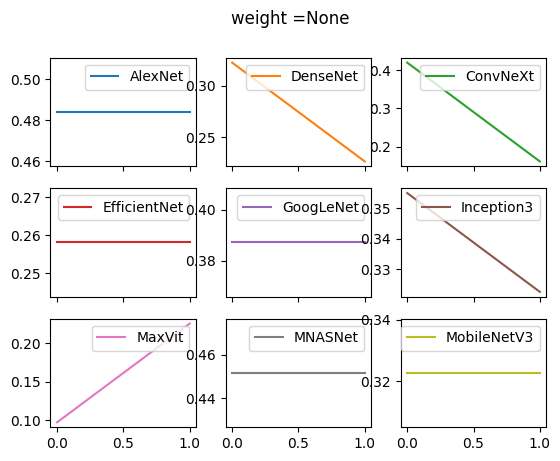

In [209]:
loss_tracking_all, error_rate_tracking_all = pd.DataFrame(), pd.DataFrame()
for model_constructor, transforms_needed in models_to_try:

    (inputs, input_files, labels), (match_targets, match_files, match_labels) = K.load_data(data_path, transforms_needed)
    inputs, match_targets = inputs.to(device), match_targets.to(device)

    model = K.FeaturesExtractor(model_constructor, weights="DEFAULT", frozen=False)
    model.to(device)
    print(f"{model.name}:")

    loss_tracking, error_rate_tracking = K.model_trainer(model, inputs, match_targets, labels, match_labels, 
                                                         iter_num = 15, k_in_topk = 5, learn_rate=0.00005) #refactor from above
    print(f"{model.name} Done, inital topk error rate = {error_rate_tracking[0]*100: .1f}%, best = {min(error_rate_tracking)*100 :.1f}%\n")
    loss_tracking_all[model.name] = loss_tracking
    error_rate_tracking_all[model.name] = error_rate_tracking

if device == "cuda":
    torch.cuda.empty_cache()
plt.close()
plt.figure()
error_rate_tracking_all.plot(subplots = True, layout = (3,3))

As shown above, the performance improvement is not only seen in AlexNet. DenseNet, ConvNeXt, EfficientNet, GoogLeNet also showed improvement in error rate after orthogonazation. With ConvNeXt preform the best after 4 training cycles. However this method does not work for all models, this possibly results from model architecture. See the discussion section.

## Results and Discussion


### Is the improvemwnt a result of random walk?

In [ ]:
loss_tracking_all, error_rate_tracking_all = pd.DataFrame(), pd.DataFrame()
for model_constructor, transforms_needed in models_to_try:

    (inputs, input_files, labels), (match_targets, match_files, match_labels) = K.load_data(data_path, transforms_needed)
    inputs, match_targets = inputs.to(device), match_targets.to(device)

    model = K.FeaturesExtractor(model_constructor, weights=None, frozen=False) # set to NO pretrain weight 
    model.to(device)
    print(f"{model.name}:")

    loss_tracking, error_rate_tracking = K.model_trainer(model, inputs, match_targets, labels, match_labels, 
                                                         iter_num = 50, k_in_topk = 5, learn_rate=0.00005) #refactor from above
    print(f"{model.name} Done, inital topk error rate = {error_rate_tracking[0]*100: .1f}%, best = {min(error_rate_tracking)*100 :.1f}%\n")
    loss_tracking_all[model.name] = loss_tracking
    error_rate_tracking_all[model.name] = error_rate_tracking

if device == "cuda":
    torch.cuda.empty_cache()
plt.close()
plt.figure()
error_rate_tracking_all.plot(subplots = True, layout = (3,3))

As shown above, For a randomly initialized model, this results in random-walk-like behavior.

Repeat this experiment 50 times, we can do some statics inferrnece on it.

In [216]:
# this cell take VERY LONG time to run!! (~ 75min in colab with T4 GPU)
from itertools import product

drawdown_records = {"DEFAULT": pd.DataFrame(), None: pd.DataFrame()}

for (model_constructor, transforms_needed), weight in product(models_to_try, ["DEFAULT", None]):

    (inputs, input_files, labels), (match_targets, match_files, match_labels) = K.load_data(data_path, transforms_needed)
    inputs, match_targets = inputs.to(device), match_targets.to(device)
    
    record = []
    for iter_id in range(50):
        model = K.FeaturesExtractor(model_constructor, weights = weight, frozen=False)
        model.to(device)

        _, error_rate_tracking = K.model_trainer(model, inputs, match_targets, labels, match_labels, 
                                                            iter_num = 15, k_in_topk = 5, learn_rate=0.00005) #refactor from above
        print(f"cycle {iter_id+1} for {model.name}done", end=" ")
        
        record.append(error_rate_tracking[0] - min(error_rate_tracking))  
    drawdown_records[weight][model.name] = record      

if device == "cuda":
    torch.cuda.empty_cache()

c:\Users\kit97\Documents\GitHub\PaddleLearing\.conda\lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
c:\Users\kit97\Documents\GitHub\PaddleLearing\.conda\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


cycle 1 for AlexNetdone cycle 2 for AlexNetdone cycle 3 for AlexNetdone cycle 4 for AlexNetdone cycle 5 for AlexNetdone cycle 6 for AlexNetdone cycle 7 for AlexNetdone cycle 8 for AlexNetdone cycle 9 for AlexNetdone cycle 10 for AlexNetdone cycle 1 for AlexNetdone cycle 2 for AlexNetdone cycle 3 for AlexNetdone cycle 4 for AlexNetdone cycle 5 for AlexNetdone cycle 6 for AlexNetdone cycle 7 for AlexNetdone cycle 8 for AlexNetdone cycle 9 for AlexNetdone cycle 10 for AlexNetdone 

KeyboardInterrupt: 

In [ ]:
avg_improvment = pd.concat([drawdown_records[None].mean(), drawdown_records["DEFAULT"].mean()], axis = 1)
avg_improvment = avg_improvment.T.rename(index = {0: "random", 1: "pretrain"})
print(avg_improvment)

The improvement (measured in init_error_rate - best_error_rate) of pre-trained model is a few times bigger than improvement of the random model. Especially for AlexNet, ConvNeXt both showed significant improvements.

Assuming the improvement of models are normally distributed, with null hypothesis of (improvement of randomly initialized models have and same mean as improvement of pre-trained models). The result of Welch's t-test for unequal variances is shown below:

In [ ]:
import scipy.stats as stats
for col in drawdown_records["DEFAULT"]:
    result = stats.ttest_ind(drawdown_records["DEFAULT"][col], drawdown_records[None][col], equal_var=False)
    print(f" the p-value for {col}: \tpython{result.pvalue: .3e}")

The p-value is well below 0.05, so it's very unlikely a result of a random event.
The normal probability plots for the randomly initialized models are shown below:

In [ ]:
plt.figure(figsize=(10, 10))
for i, col in enumerate(drawdown_records[None], 1):
    plt.subplot(3,3,i)
    stats.probplot(stats.zscore(drawdown_records[None][col]), dist="norm", plot=plt)
    plt.title(col)
plt.tight_layout()
plt.show()

Although due to the small size of the data set, there are steps in data, the general shape still follows a normal distribution, with exceptions of EfficientNet, GoogLeNet, MNASNet, and MobileNetV3.

The underlying distribution of improvement measurement is very unlikely to be the true normal distribution, however, this should able to give a decent estimation of the validity of this method.

### Why does this method only work for some models?

When we take a closer look at the result, the behaviors of models in training can be divided into three classes.
1. Steady decrease at first. (AlexNet, ConvNeXt, DenseNet)
2. Steady increase first. (MaxVit, MNASNet)
3. No clear trend. (EfficientNet, GoogLeNet, Inception3, MobileNetV3)

For AlexNet[11] and ConvNeXt[12], are the only two models with pure convolution layers as building blocks.
DenseNet[13] contains densely connected convolutional modules.
GoogLeNet[14] and Inception3[15]'s core budling block is Inception module. 
EfficientNet[16], MNASNet[17], MobileNetV3[18] all contain residual modules or inverted residual modules.
MaxVit[19] is transformer architecture.

This implies that this method may only work for pure convolutional neural networks. The mechanism behind this is yet to be further studied.

### Why increased training result in poor accuracy?

One possibility is that after some iter the featurizer starts to "forget" what it learned from the training dataset(ImageNet), instead trying to minimize the dot-products, which itself will not improve quality of feature extraction.

### This method also work for differnet k

In [ ]:
(inputs, input_files, labels), (match_targets, match_files, match_labels) = K.load_data(data_path, transforms_default)
inputs, match_targets = inputs.to(device), match_targets.to(device)

error_rate_tracking_diff_k = pd.DataFrame()

for k_in_topk in range(1,6):

    model = K.FeaturesExtractor(models.alexnet, weights="DEFAULT", frozen=False)
    model.to(device)
    print(f"{model.name}:")

    _, error_rate_tracking = K.model_trainer(model, inputs, match_targets, labels, match_labels, 
                                                         iter_num = 15, k_in_topk = k_in_topk, learn_rate=0.00005) #refactor from above
    print(f"{model.name} Done, inital topk error rate = {error_rate_tracking[0]*100: .1f}%, best = {min(error_rate_tracking)*100 :.1f}%\n")
    error_rate_tracking_diff_k[f"k = {k_in_topk}"] = error_rate_tracking

if device == "cuda":
    torch.cuda.empty_cache()
plt.close()
plt.figure()
plt.tight_layout()
error_rate_tracking_diff_k.plot(subplots = True, layout = (5,1))

### Future work on
1. if labeled data is available, try SIAMESE CNN
2. Use other kinds of metrics to determin the similarity, i.e. L2-norm, L1-norm for non-unity vectors
3. Other kinds of feather extraction methods, such as SIFT, SURF, BRIEF, BRISK, and FAST.

## Method and Impleatation

### Data

Due to the lack of such pairing datasets in the fashion domain. Most available fashion datasets[8-10] are image labeled with descriptions or classes, rather than a pairing datasets. The available image pair datasets are designed for facical reconigtion[6], and semantic similarity[7].

The data used for this notebook is collected by myself on an online store of a big fashion retailer. Thus the dataset is relatively small(17 target photos and 30 querys photos), which might diminish the viability of this method. 

Thus one further improvement of this work is to collect more data, possibly by web crawler. Also wider range of data, such as including other stores and other sources, such as photos in the comment section on e-commerce. So that bias in the dataset is eliminated. 

However, due to the lack of suitable datasets, skills for making web crawler, and resources to collect more data at this moment, this potentially biased dataset is used for preliminary results.

### Code

All code is written in Python with Pytorch package. All code and images used are available on Github(https://github.com/kit971103/ImageMatching).

## Reference
1-3 are works done on Similarity model with labeled data\
4-5 are Template Matching


1. Chatterjee, Moitreya; Luo, Yunan. Course material from University of Illinois, "Similarity Learning with (or without) Convolutional Neural Network" (PDF). https://slazebni.cs.illinois.edu/spring17/lec09_similarity.pdf
2. 
3. 
4. OpenCV Template Matching, https://docs.opencv.org/2.4.13.7/doc/tutorials/imgproc/histograms/template_matching/template_matching.html
5. IMAGE MATCH GITHUB, https://github.com/rhsimplex/image-match
6. Labeled Faces in the Wild, https://vis-www.cs.umass.edu/lfw/index.html
7. Images Alike, semantic similar image pair, https://www.kaggle.com/datasets/alincijov/images-alike
8. Fashion Product Images Dataset, https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
9. Adidas Fashion Retail Products Dataset, https://www.kaggle.com/datasets/thedevastator/adidas-fashion-retail-products-dataset-9300-prod
10. Clothing dataset ,https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full
11. "One weird trick for parallelizing convolutional neural networks", https://arxiv.org/pdf/1404.5997.pdf
12. "A ConvNet for the 2020s",https://arxiv.org/pdf/2201.03545.pdf
13. "Densely Connected Convolutional Networks", https://arxiv.org/pdf/1608.06993.pdf
14. "Going deeper with convolutions", https://arxiv.org/pdf/1409.4842.pdf
15. "Rethinking the Inception Architecture for Computer Vision", https://arxiv.org/pdf/1512.00567.pdf
16. "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks", https://arxiv.org/pdf/1905.11946.pdf
17. "MnasNet: Platform-Aware Neural Architecture Search for Mobile", https://arxiv.org/pdf/1807.11626.pdf
18. "MobileNetV2: Inverted Residuals and Linear Bottlenecks", https://arxiv.org/pdf/1801.04381.pdf
19. "MaxViT: Multi-Axis Vision Transformer", https://arxiv.org/pdf/2204.01697.pdf

### Real Motivation
On a road trip with my friends, one of my friends who owns a fashion business needed to work in a hotel room, while watching he work, I found that most of his work was pretty mechanical. There are two major tasks:
1. Product matching, match the product photo taken by the employee to a sample photo from the supplier for the internal inventory system.
2. Table recognition, manual input sale data from photo containing a table of daily sale record

"it should be an easy task for AI" I thought it should be easy to build a tool with existing resources. \
I was wrong. VERY WRONG\
At least not easy for me who knew nothing about programming at that time.

For the table recognition task, I tried a few online tools and most of them are horrible at identifying hand-written tables. Then I switched to using paddlepaddle(an ML package by China internet giant  BAIDU)